# AIsteroid
[http://bit.ly/aisteroid](http://bit.ly/aisteroid)

In [1]:
from aisteroid import *
%matplotlib nbagg

## Task: Uncompress and read the image set

### Choose the image set

In [2]:
#listImages() ##See the list of imagesets
#CONF.SET="example" ##Choose your preferred imageset
#CONF.CFG="example" ##You choose your preferred observatory configuration (example.cfg)
#CONF.OVERWRITE=1 ##Overwrite all previous actions

#### DO NOT TOUCH IF YOU ARE NOT SURE

In [3]:
#DO NOT MODIFY THIS LINES
print0("*"*60+"\nUNPACKING SET '%s'\n"%CONF.SET+"*"*60)
OUT_DIR=CONF.SCR_DIR+CONF.SET+"/"
CFG=[line.rstrip('\n') for line in open(CONF.SETS_DIR+CONF.CFG+".cfg")]
AIA=dict()
AIA_FILE=OUT_DIR+CONF.SET+".aia"
SET_FILE=CONF.SETS_DIR+CONF.SET+".zip"
PLOT_DIR=OUT_DIR+"plots/"
if not os.path.isfile(SET_FILE):
    error("No set file '%s'"%setfile)

************************************************************
UNPACKING SET 'example'
************************************************************


### Unpack the images

In [4]:
print0("Unpacking images of set %s"%(CONF.SET))
if not os.path.isdir(OUT_DIR) or CONF.OVERWRITE:
    out=System("rm -rf "+OUT_DIR)
    out=System("mkdir -p "+OUT_DIR)
    out=System("mkdir -p "+PLOT_DIR)
    out=System("unzip -j -o -d "+OUT_DIR+" "+SET_FILE)
    pickle.dump(AIA,open(AIA_FILE,"wb"))
else:
    print0("\tAlready unpacked.")
    AIA=pickle.load(open(AIA_FILE,"rb"))
print0("\tDone.")

Unpacking images of set example
Archive:  /home/astrometry/iasc/data/sets/example.zip
  inflating: /home/jzuluaga/Astrometry/AIsteroid/scratch/example/o8009g0138o.1300012.ch.1991800.XY51.p10.fits
  inflating: /home/jzuluaga/Astrometry/AIsteroid/scratch/example/o8009g0096o.1299970.ch.1991758.XY51.p10.fits
  inflating: /home/jzuluaga/Astrometry/AIsteroid/scratch/example/o8009g0117o.1299991.ch.1991779.XY51.p10.fits
  inflating: /home/jzuluaga/Astrometry/AIsteroid/scratch/example/o8009g0075o.1299949.ch.1991737.XY51.p10.fits
	Done.


### Read the images

In [9]:
images=[]

if not "images" in AIA.keys() or CONF.OVERWRITE:

    print0("Reading images")
    for img in sorted(glob.glob(OUT_DIR+"*.fits")):

        #Dictionary to store image information
        image=dict()
        image["file"]=img.split("/")[-1].replace(".fits","")

        print0("\tReading image %s"%(image["file"]))


        #Open fits image
        hdul=fits.open(img)

        #Get basic information
        image["header"]=hdul[0].header
        image["data"]=hdul[0].data

        #Example of how the information stored in the header is recovered
        image["obstime"]=hdul[0].header["DATE-OBS"]
        image["unixtime"]=date2unix(image["obstime"])

        #Close fits image
        hdul.close()

        #Save a plain data
        f=open(OUT_DIR+"%s.head"%image["file"],"w")
        f.write(image["header"].tostring("\n"))
        f.close()

        #Add image to list of images
        images+=[image]

    print("\tDone.")
    nimgs=len(images)
    print("Number of images: %d"%nimgs)

    #Telescope and camera (detector) properties
    detector=dictObj(dict())
    print("\tTelescope & CCD Properties:")
    detector.FOCAL=Config(CFG,"FocalLength") #mm
    detector.PW=Config(CFG,"PixelWide") #mm
    detector.PH=Config(CFG,"PixelHigh") #mm
    detector.SIZEX=images[0]["header"]["NAXIS1"]
    detector.SIZEY=images[0]["header"]["NAXIS2"]
    detector.PWD=np.arctan(detector.PW/detector.FOCAL)*RAD
    detector.PHD=np.arctan(detector.PW/detector.FOCAL)*RAD
    detector.PXSIZE=(detector.PWD+detector.PHD)/2
    print("\t\tFocal lenght (mm) :",detector.FOCAL)
    print("\t\tPixel size (x mm,y mm) :",detector.PW,detector.PH)
    print("\t\tImage size (x px,y px) :",detector.SIZEX,detector.SIZEY)
    print("\t\tPixel size (arcsec):",detector.PXSIZE/ARCSEC)
    print("\t\tCamera field (x deg,y deg) :",detector.SIZEX*detector.PWD,detector.SIZEY*detector.PHD) 
    
    #Store the images information into the AIA dictionary
    AIA["detector"]=detector
    AIA["images"]=images
    pickle.dump(AIA,open(AIA_FILE,"wb"))
    
else:
    print("Images already read.")
    AIA=pickle.load(open(AIA_FILE,"rb"))
    images=AIA["images"]
    nimgs=len(images)
print0("\tDone.")

Reading images
	Reading image o8009g0075o.1299949.ch.1991737.XY51.p10
	Reading image o8009g0096o.1299970.ch.1991758.XY51.p10
	Reading image o8009g0117o.1299991.ch.1991779.XY51.p10
	Reading image o8009g0138o.1300012.ch.1991800.XY51.p10
	Done.
Number of images: 4
	Telescope & CCD Properties:
		Focal lenght (mm) : 8070.0
		Pixel size (x mm,y mm) : 0.01 0.01
		Image size (x px,y px) : 2423 2434
		Pixel size (arcsec): 0.255594555449
		Camera field (x deg,y deg) : 0.172029335514 0.172810318878
	Done.


### Show the images

Showing images
	Done.


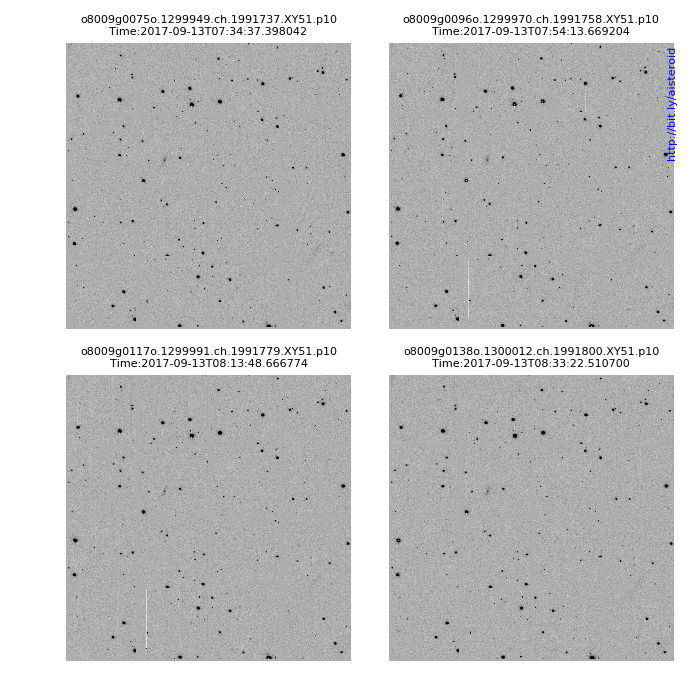

In [10]:
plotfile=PLOT_DIR+"cascade-%s.png"%CONF.SET
if CONF.QPLOT:
    plt.ioff() ##Comment to see interactive figure

    if not os.path.isfile(plotfile) or CONF.OVERWRITE:

        print0("Showing images")

        ncols=2
        nrows=int(nimgs/ncols)

        #Area of plotting
        fig,axs=plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(7,7))

        #Common options for plotting
        imgargs=dict(cmap='gray_r',vmin=0,vmax=500)

        for i,ax in enumerate(mat2lst(axs)):
            ax.imshow(images[i]["data"],**imgargs)
            ax.axis("off")
            otime=images[i]["header"]["DATE-OBS"]
            ax.set_title(images[i]["file"]+"\n"+"Time:"+otime,fontsize=8,position=(0.5,1.0))

        fig.tight_layout()
        waterMark(axs[0,1])
        fig.savefig(plotfile)
    else:
        if CONF.QPLOT:print0("Image '%s' already generated."%plotfile)
    print0("\tDone.")
Image(filename=plotfile)

### Blink all image

Blink images (all)
	Done.


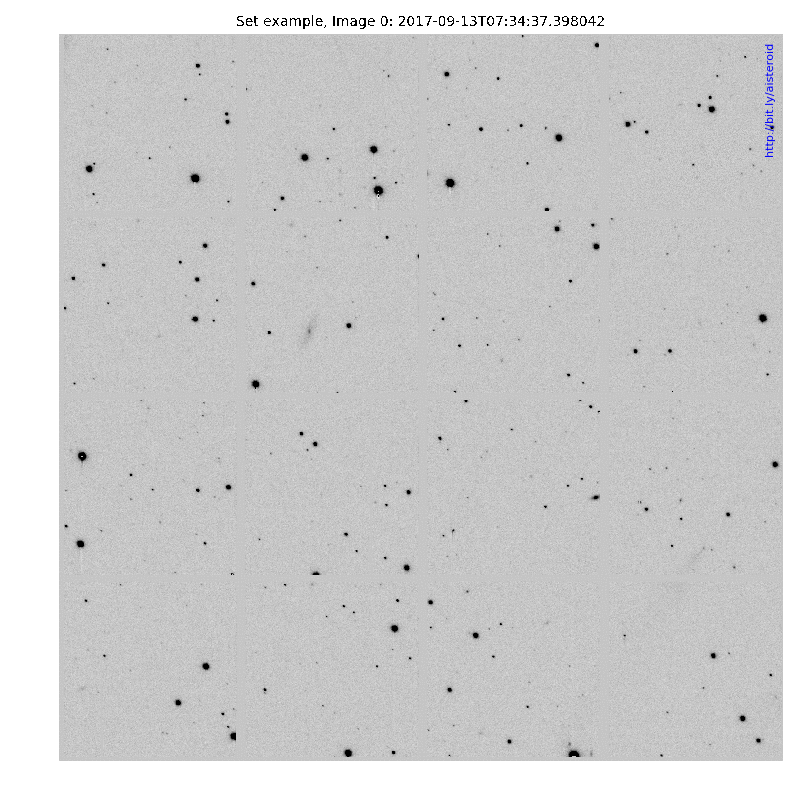

In [11]:
plotfile="%s/blinkall-%s.gif"%(PLOT_DIR,CONF.SET)
if CONF.QPLOT:
    plt.ioff() ##Comment to see interactive figure

    if (not os.path.isfile(plotfile) or CONF.OVERWRITE) and CONF.QPLOT:

        print0("Blink images (all)")

        #Basic figure
        fig=plt.figure(figsize=(8,8))
        imgargs=dict(cmap='gray_r',vmin=0,vmax=700)
        im=plt.imshow(images[0]["data"],animated=True,**imgargs)
        tm=plt.title("Set %s, Image 0: "%CONF.SET+images[0]["obstime"],fontsize=10)
        waterMark(fig.gca())
        plt.axis("off")
        fig.tight_layout()

        def updatefig(i):
            iimg=i%nimgs
            im.set_array(images[iimg]["data"])
            tm.set_text("Set %s, Image %d: "%(CONF.SET,iimg)+images[iimg]["obstime"])
            return im,

        #Create animation
        ani=animation.FuncAnimation(fig,updatefig,frames=range(nimgs),
                                    interval=1000,repeat_delay=1000,
                                    repeat=True,blit=True)
        saveAnim(ani,PLOT_DIR,plotfile)
    else:
        if CONF.QPLOT:print0("Image '%s' already generated."%plotfile)
    print0("\tDone.")
Image(filename=plotfile)

Blink images (sections)
	Done.


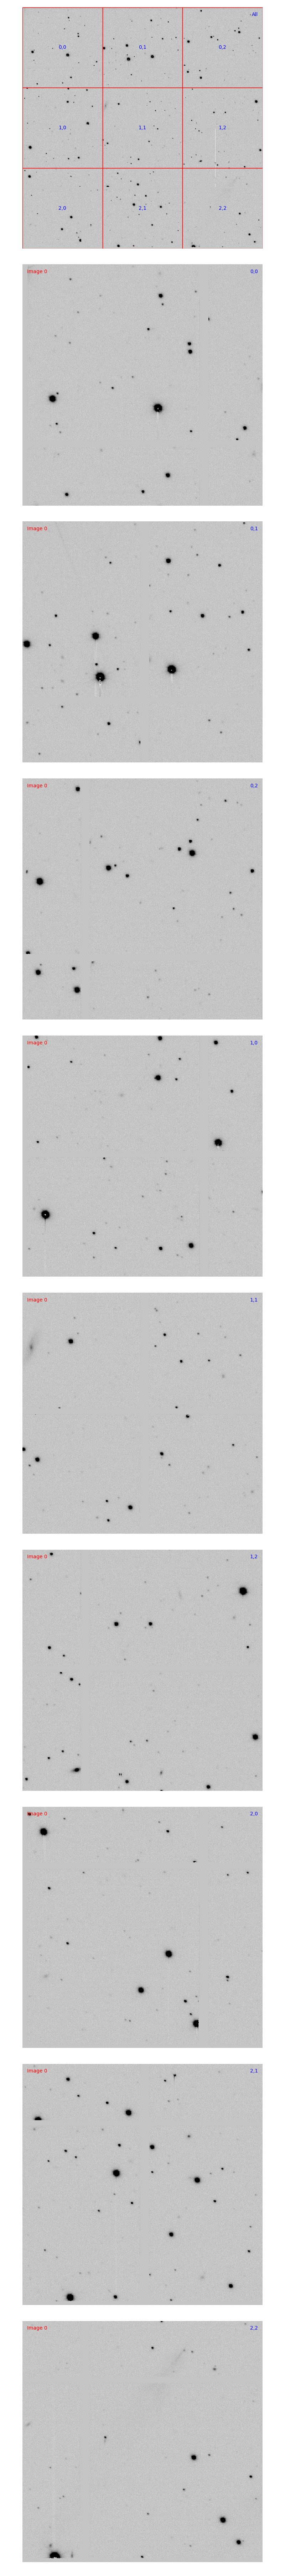

In [12]:
plotfile="%s/blink-%s.gif"%(PLOT_DIR,CONF.SET)
if CONF.QPLOT:
    plt.ioff() ##Comment to see interactive figure

    if (not os.path.isfile(plotfile) or CONF.OVERWRITE) and CONF.QPLOT:
        print0("Blink images (sections)")

        data=images[0]["data"]
        nrows,ncols=data.shape
        drows=int(nrows/3)
        dcols=int(ncols/3)
        ratio=(1.0*drows)/dcols

        fig=plt.figure(figsize=(8,8*ratio*9),)

        axs=[]
        axs+=[fig.add_subplot(10,1,1)]
        axs+=[fig.add_subplot(10,1,2)]
        for i in range(8):axs+=[fig.add_subplot(10,1,3+i,sharex=axs[1],sharey=axs[1])]


        ax=axs[0]
        imgargs=dict(cmap='gray_r',vmin=0,vmax=700)
        ims00=ax.imshow(data,animated=True,**imgargs)
        ax.axis("off")
        ax.set_adjustable('box-forced')
        ax.text(0.98,0.98,"All",color='b',transform=ax.transAxes,ha='right',va='top')

        n=1
        ims=[]
        txs=[]
        for i in range(3):
            im=[]
            tx=[]
            for j in range(3):
                irow=i*drows
                icol=j*dcols
                subimg=data[irow:irow+drows,icol:icol+dcols]

                axs[0].add_patch(pat.Rectangle([icol,irow],dcols,drows,color='r',fc='None'))
                axs[0].text(icol+dcols/2,irow+drows/2,"%d,%d"%(i,j),color='b',ha='center',va='center')

                ax=axs[n]
                im+=[ax.imshow(subimg,animated=True,**imgargs)]
                tx+=[ax.text(0.02,0.98,"Image 0",color='r',transform=ax.transAxes,ha='left',va='top')]
                ax.text(0.98,0.98,"%d,%d"%(i,j),color='b',transform=ax.transAxes,ha='right',va='top')
                ax.axis("off")
                ax.set_xlim((0,dcols))
                ax.set_ylim((drows,0))
                ax.set_adjustable('box-forced')
                n+=1
            ims+=[im]
            txs+=[tx]
        fig.tight_layout()

        def updatefig(i):
            iimg=i%nimgs
            data=images[iimg]["data"]
            ims00.set_array(data)
            for i in range(3):
                for j in range(3):
                    irow=i*drows
                    icol=j*dcols
                    subimg=data[irow:irow+drows,icol:icol+dcols]
                    ims[i][j].set_array(subimg)
                    txs[i][j].set_text("Image %d"%iimg)
            return ims00,

        #Create animation
        ani=animation.FuncAnimation(fig,updatefig,frames=range(nimgs),
                                    interval=1000,repeat_delay=1000,
                                    repeat=True,blit=True)
        saveAnim(ani,PLOT_DIR,plotfile)
    else:
        print0("Image '%s' already generated."%plotfile)
    print0("\tDone.")    
Image(filename=plotfile)